## geneated data

2493359643


Text(0, 0.5, 'Input Value')

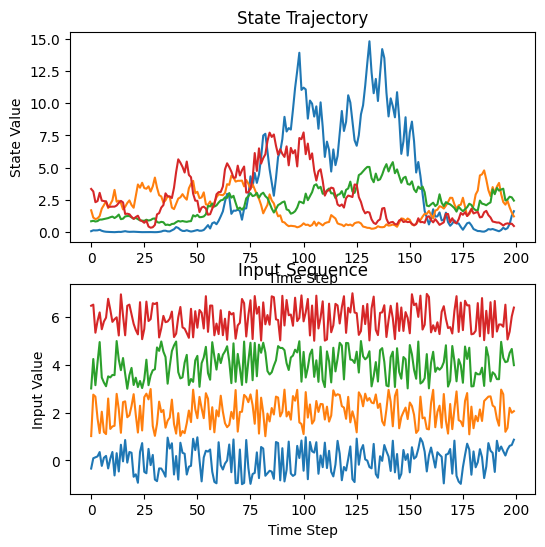

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))

# from utils import dynamics_analysis
num_regions = 10   # 状态变量数量
num_states=num_regions
num_inputs = 4   # 控制输入数量
num_observed = 4
np.random.seed(800)

# Sigmoid 激活函数
def sigmoid(x, a, theta):
    return 1 / (1 + np.exp(-a * (x - theta))) - 1 / (1 + np.exp(a * theta))

dt=0.05
# Wilson-Cowan 模型方程
def wilson_cowan(y, W_EE, W_EI, W_IE, W_II, r, E_tau, E_a, E_theta, I_tau, I_a, I_theta, I_ext_E, I_ext_I):
    num_regions = W_EE.shape[0]
    E = y[:num_regions]  # 兴奋性神经元的活动
    I = y[num_regions:]  # 抑制性神经元的活动
    
    # 兴奋性神经元活动
    input_E = W_EE @ E - W_EI @ I + I_ext_E
    # 抑制性神经元活动
    input_I = W_IE @ E - W_II @ I + I_ext_I
    E = E+dt* (-E + (1 - r * E) * sigmoid(input_E, E_a, E_theta)) / E_tau
    
    I = I+dt* (-I + (1 - r * I) * sigmoid(input_I, I_a, I_theta)) / I_tau
    
    return np.concatenate([E, I])


# 连接权重矩阵 (10x10)
W_EE = np.random.rand(num_regions, num_regions) * 2  # 兴奋性到兴奋性
W_EI = np.random.rand(num_regions, num_regions) * 1  # 抑制性到兴奋性
W_IE = np.random.rand(num_regions, num_regions) * 1  # 兴奋性到抑制性
W_II = np.random.rand(num_regions, num_regions) * 1  # 抑制性到抑制性
B = 5*np.random.uniform(-3, 3, (num_regions, num_inputs)) # 控制矩阵
C = np.random.uniform(-10, 10, (num_observed, num_regions)) # 控制矩阵
# 确保自连接权重较大
np.fill_diagonal(W_EE, 12)
np.fill_diagonal(W_EI, 4)
np.fill_diagonal(W_IE, 13)
np.fill_diagonal(W_II, 11)

# 其他参数
dt=0.05
r=1
E_tau=1
E_a=1.2
E_theta=0.1
I_tau=1
I_a=1
I_theta=0.1

# 初始条件
E0 = np.random.rand(num_regions) * 0.1  # 初始兴奋性活动
I0 = np.random.rand(num_regions) * 0.1  # 初始抑制性活动
y0 = np.vstack((E0, I0)).flatten()

# 时间范围
t_span = (0, 100)  # 模拟时间范围
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # 时间点

# 求解微分方程
def generate_random_inputs(num_steps, num_inputs, input_min, input_max):
    """生成随机控制输入序列"""
    return np.random.uniform(input_min, input_max, (num_steps, num_inputs))

num_steps = 16000  # 仿真步数
# 设置输入的幅值范围
input_min = -1
input_max = 1
# 初始化状态和输入
x = np.zeros((num_steps, num_regions*2))  # 状态序列
y = np.zeros((num_steps, num_observed))  # 状态序列
u = generate_random_inputs(num_steps, num_inputs, input_min, input_max)  # 随机输入

# 初始状态（可以设置为零或者随机初始化）
x[0, :] = np.random.uniform(-1, 1, num_regions*2)
y[0:1, :] = 3*np.log(1+np.exp(C@(x[0:1,:num_regions].T)).T)

# 执行仿真，生成数据
for t in range(1, num_steps):
    # x[t, :] = np.tanh(A @ x[t-1, :] + B @ u[t, :])
    x[t, :] = wilson_cowan(x[t-1, :], W_EE, W_EI, W_IE, W_II, r, E_tau, E_a, E_theta, I_tau, I_a, I_theta, B @ u[t, :], np.zeros(num_regions))
    y[t:t+1, :] = 3*np.log(1+np.exp(C@(x[t:t+1,:num_regions].T)).T)


state = np.random.get_state()
current_state = state[1][0]
print(current_state)

y=y[200:,:]
u=u[200:,:]
x=x[200:,:]

plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
for i in range(num_observed):
    plt.plot(y[:200, i], label="State %d"%(i+1))
plt.title("State Trajectory")
plt.xlabel("Time Step")
plt.ylabel("State Value")
#plt.legend()

plt.subplot(2, 1, 2)
for i in range(4):
    plt.plot(u[:200, i]+2*i, label="Input %d"%(i+1))
plt.title("Input Sequence")
plt.xlabel("Time Step")
plt.ylabel("Input Value")
# plt.legend()

## constuct surrogate model

In [2]:
from utils.DataSample import Input_Data
from torch.utils.data.sampler import SubsetRandomSampler
import torch
from utils.training_utils import train_model, model_prediction_, model_prediction_forloop
from utils.Models import Latent_Model
Tp_length = 20
device = torch.device('cuda:0')
simple_params = {'Num_Cortical': num_states,
                'Tp': Tp_length,
                'data_length': 101,  # Hyperparameter
                'ext_input_dim':4
            }
input_data = Input_Data(simple_params, y.T,u.T,x.T)

dataset_size = len(input_data)

indices = list(range(dataset_size))
train_indices = indices[:int(0.7*dataset_size)]
val_indices = indices[int(0.7*dataset_size):]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
train_dataloader = torch.utils.data.DataLoader(input_data, batch_size=300,
                                                sampler=train_sampler, num_workers=4)
validation_dataloader = torch.utils.data.DataLoader(input_data, batch_size=300,
                                                    sampler=valid_sampler)

hidden_dim=50
X, ext_in, start_indexs = next(iter(validation_dataloader))
model_params={'EI_ratio': 4,
              'Tp': Tp_length,
                'sparsity': 0,
                'e_clusters': 2,
                'i_clusters': 1,
                'inter_or_intra': 'Inter',
                'data_length': simple_params['data_length'], #101,  # Hyperparameter
                'HIDDEN_DIM': hidden_dim,
                'LATENT_DIM': hidden_dim,
                'ext_input_dim':4,
                'IN_DIM':4,
                'activation': 'ReLU',
                'final_activation': 'Softplus',
                'RNN_Type': 'EI-RNN', # 'my_VAR',# 'AR', #'GRU' ,# 'AR' #
                'with_Tanh': True,
                'fr_type':True,
                'num_folder': 1,
                'device':device,
                'with_wrec_perturbation':False,
                'with_b_perturbation':False}


In [3]:
model = Latent_Model(model_params).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)
            
epochs=300
ckpts_eirnn = 'wilson_cowan_spon_data_with_tanh_dt_%.2f.pth'%dt  # 0413 loss = 0.067
ckpts_var = 'var_wilson_cowan_spon_data_dt_%.2f.pth'%dt
# ckpts = 'wilson_cowan_spon_data_without_tanh_0417.pth'
# print(model)

# ckpts_eirnn = './wc_model/eirnn_dt_%.2f_fold_%d.pth'%(dt,2)  # 0413 loss = 0.067
ckpts_var = './wc_model/y_x_var_dt_%.2f_fold_%d.pth'%(dt,2)
# ckpts_var = './wc_model/var_dt_%.2f_fold_%d.pth'%(dt,9)

run_device: cuda:0


In [4]:
model = train_model(model,train_dataloader,validation_dataloader,optimizer,epochs,ckpts_eirnn,device)
torch.save(model.state_dict(),ckpts_eirnn)
model.load_state_dict(torch.load(ckpts_eirnn))

[ 20/300] train_loss: 0.50928 valid_loss: 0.53301 hid_loss: 0.03095 pred_loss: 0.47833
[ 40/300] train_loss: 0.40874 valid_loss: 0.45944 hid_loss: 0.03298 pred_loss: 0.37576
[ 60/300] train_loss: 0.38139 valid_loss: 0.41477 hid_loss: 0.03605 pred_loss: 0.34534
[ 80/300] train_loss: 0.37327 valid_loss: 0.40247 hid_loss: 0.03979 pred_loss: 0.33348
[100/300] train_loss: 0.35397 valid_loss: 0.39292 hid_loss: 0.03919 pred_loss: 0.31478
[120/300] train_loss: 0.36427 valid_loss: 0.40409 hid_loss: 0.03932 pred_loss: 0.32496
[140/300] train_loss: 0.34274 valid_loss: 0.37268 hid_loss: 0.03804 pred_loss: 0.30470
[160/300] train_loss: 0.34367 valid_loss: 0.40514 hid_loss: 0.03866 pred_loss: 0.30501
[180/300] train_loss: 0.33324 valid_loss: 0.36564 hid_loss: 0.03905 pred_loss: 0.29419
[200/300] train_loss: 0.31122 valid_loss: 0.36001 hid_loss: 0.04121 pred_loss: 0.27001
Validation loss decreased (inf --> 0.346537).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of

<All keys matched successfully>

## Evaluation

total_params: 5804
R2: 0.9022530103464227 _std: 0.016983062107521107 

MSE: 0.3577720715448277 _std: 0.14531680258253052 

EV: 0.9144831655456033 _std: 0.01250302564840925 

CC: 0.9428693002198529 _std: 0.011127921778566053 



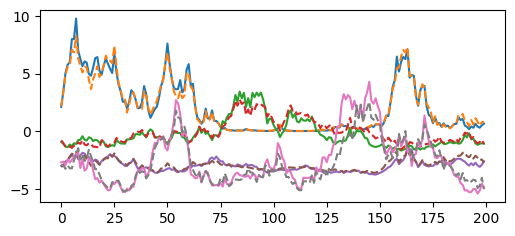

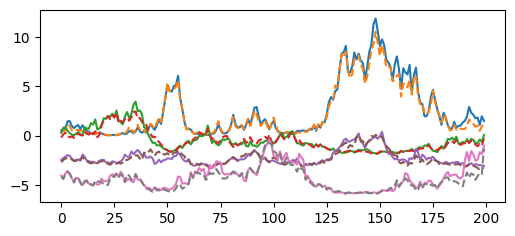

In [5]:
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error, explained_variance_score, matthews_corrcoef
print('total_params:',sum(p.numel() for p in model.parameters() if p.requires_grad))
statistic_result1 = {
            'R2': np.zeros((1, 30)),
            'mse': np.zeros((1, 30)),
            'EV': np.zeros((1, 30)),
            'CC': np.zeros((1, 30)),
            'R2_by_channel': np.zeros((1, 30, 4)),
            'EV_by_channel': np.zeros((1, 30, 4)),
            'mse_by_channel': np.zeros((1, 30, 4)),
        }
time_length = 500 
prediction_result = np.zeros([30, time_length, 4])
gt_ = np.zeros([30, time_length, 4])


for run_index in range(30):
    # print('step %d'%run_index)
    if start_indexs[-run_index] < input_data.X.shape[0] :
        start_index = start_indexs[-run_index]
    else:
        start_index = input_data.X.shape[0]
    # print('start_index:',start_index)
    #from sklearn.feature_selection import r_regression
    prediction_result[run_index,:,:],gt_[run_index,:,:]=model_prediction_forloop(model,input_data,start_index,time_length,Tp_length,device)
    statistic_result1['R2'][0, run_index] = r2_score(gt_[run_index,:, :], prediction_result[run_index, :, :],multioutput='variance_weighted')
    statistic_result1['mse'][0, run_index] =+ mean_squared_error(gt_[run_index,:, :],prediction_result[run_index, :, :])
    statistic_result1['EV'][0, run_index] = explained_variance_score(gt_[run_index,:, :],prediction_result[run_index, :, :],multioutput='variance_weighted')
    
    corr_ = np.zeros((4,))
    for k in range(4):
        #print(np.corrcoef(gt_[run_index,:, k],prediction_result[run_index,:,k]))
        corr_[k]=np.corrcoef(gt_[run_index,:, k],prediction_result[run_index,:,k])[0,1]
    statistic_result1['CC'][0, run_index] = np.mean(corr_)
    
    if run_index%15==0:
        plt.figure(figsize=(6,2.5))
        for i in range(4):
            plt.plot(gt_[run_index,:200, i]-2*i)
            plt.plot(prediction_result[run_index,:200, i]-2*i,'--')


print("R2:", np.mean(statistic_result1['R2'][0]), "_std:",
        np.std(statistic_result1['R2'][0]), "\n")
print("MSE:", np.mean(statistic_result1['mse'][0]), "_std:",
        np.std(statistic_result1['mse'][0]), "\n")  # ,
print("EV:", np.mean(statistic_result1['EV'][0]), "_std:",
        np.std(statistic_result1['EV'][0]), "\n")
print("CC:", np.mean(statistic_result1['CC'][0]), "_std:",
        np.std(statistic_result1['CC'][0]), "\n")

## initializing a mpc module

In [6]:
from utils.mpc_setup_scipy import my_mpc

model_params_mpc={
    'Wrec':model.rnn_cell.get_w_rec().detach().cpu().numpy(),
    'Wrec_bias':model.rnn_cell.bias_rec.detach().cpu().numpy(),
    'B':model.rnn_cell.B.detach().cpu().numpy(),
    'B_bias':model.rnn_cell.B_bias.detach().cpu().numpy(),
    'C':model.rnn_cell.C.detach().cpu().numpy(),
    'C_bias':model.rnn_cell.C_bias.detach().cpu().numpy(),
    'rnn_type':'EI-RNN'
}


In [7]:
ref_ = y[380,:].tolist()
ref_[0]-=0.5
ref_[2]-=0.5
ref_[3]-=0.5

cl_act_controller = my_mpc(model_params=model_params_mpc,
                            predict_length=10,
                            control_length=10,
                            ref=ref_,
                            control_strategy='Activating',
                            control_channel=None,
                            min_input=np.array([-1,-1,-1,-1]),
                            max_input=np.array([1,1,1,1]),
                            control_type='closed_loop')

ol_act_controller = my_mpc(model_params=model_params_mpc,
                            predict_length=10,
                            control_length=10,
                            ref=ref_,
                            control_strategy='Activating',
                            control_channel=None,
                            min_input=np.array([-1,-1,-1,-1]),
                            max_input=np.array([1,1,1,1]),
                            control_type='open_loop')

cl_inh_controller = my_mpc(model_params=model_params_mpc,
                            predict_length=10,
                            control_length=10,
                            ref=ref_,
                            control_strategy='Inhibiting',
                            control_channel=None,
                            min_input=np.array([-1,-1,-1,-1]),
                            max_input=np.array([1,1,1,1]),
                            control_type='closed_loop')

ol_inh_controller = my_mpc(model_params_mpc,
                            predict_length=10,
                            control_length=10,
                            ref=ref_,
                            control_strategy='Inhibiting',
                            control_channel=None,
                            min_input=np.array([-1,-1,-1,-1]),
                            max_input=np.array([1,1,1,1]),
                            control_type='open_loop')


input_dim:4  system_dim:4
input_dim:4  system_dim:4
input_dim:4  system_dim:4
input_dim:4  system_dim:4


## real system

In [8]:
dt=0.05
r=1
E_tau=1
E_a=1.2
E_theta=0.1
I_tau=1
I_a=1
I_theta=0.1

def wilson_cowan(y, W_EE, W_EI, W_IE, W_II, r, E_tau, E_a, E_theta, I_tau, I_a, I_theta, I_ext_E, I_ext_I):
    num_regions = W_EE.shape[0]
    E = y[:num_regions]  # 兴奋性神经元的活动
    I = y[num_regions:]  # 抑制性神经元的活动
    
    # 兴奋性神经元活动
    input_E = W_EE @ E - W_EI @ I + I_ext_E
    # 抑制性神经元活动
    input_I = W_IE @ E - W_II @ I + I_ext_I

    E = E+dt* (-E + (1 - r * E) * sigmoid(input_E, E_a, E_theta)) / E_tau
    I = I+dt* (-I + (1 - r * I) * sigmoid(input_I, I_a, I_theta)) / I_tau
    
    return np.concatenate([E, I])

def forward_system(x,u):
    u=np.reshape(u,(num_inputs,1))
    x = wilson_cowan(x, W_EE, W_EI, W_IE, W_II, r, E_tau, E_a, E_theta, I_tau, I_a, I_theta, B @ u[:,0], np.zeros(num_regions))
    y = 3*np.log(1+np.exp(C@(x[:num_regions])))
    return x,y

np.random.seed(None)

In [9]:
def model_encode(model,x):
    latent_x = model.encode(torch.from_numpy(np.reshape(x,(1,1,num_observed)).astype('float32')).to('cuda:0'))
    #print(latent_x.shape)
    return np.reshape(latent_x.detach().cpu().numpy(),(model_params['HIDDEN_DIM'],1))

In [10]:
ref_ = y[380,:].tolist()
ref_[0]-=0.5
ref_[2]-=0.5
ref_[3]-=0.5

    
print(ref_)
cl_tracking_controller = my_mpc(model_params=model_params_mpc,
                                predict_length=10,
                                control_length=10,
                                ref=ref_,
                                control_strategy='Tracking',
                                control_channel=None,
                                is_WC=True,
                                min_input=np.array([-1,-1,-1,-1]),
                                max_input=np.array([1,1,1,1]),
                                control_type='closed_loop')

ol_tracking_controller = my_mpc(model_params=model_params_mpc,
                                predict_length=10,
                                control_length=10,
                                ref=ref_,
                                control_strategy='Tracking',
                                control_channel=None,
                                is_WC=True,
                                min_input=np.array([-1,-1,-1,-1]),
                                max_input=np.array([1,1,1,1]),
                                control_type='open_loop')

[0.9337094550809772, 2.051743712299901, 0.9664812574976969, 1.581768736995738]
input_dim:4  system_dim:4
input_dim:4  system_dim:4


## running tracking reference

In [11]:
trials = 10
num_steps=51

x_ol_track = np.zeros((trials,num_steps, num_states*2))  # 状态序列
y_ol_track = np.zeros((trials,num_steps, num_observed))  # 状态序列
u_ol_track = np.zeros((trials,num_steps, num_inputs))  # 状态序列
x_cl_track = np.zeros((trials,num_steps, num_states*2))  # 状态序列
y_cl_track = np.zeros((trials,num_steps, num_observed))  # 状态序列
u_cl_track = np.zeros((trials,num_steps, num_inputs))  # 状态序列
x_rdm_track = np.zeros((trials,num_steps, num_states*2))  # 状态序列
y_rdm_track = np.zeros((trials,num_steps, num_observed))  # 状态序列
u_rdm_track = np.zeros((trials,num_steps, num_inputs))  # 状态序列
for i in range(trials):
    x_ol_track[i, 0, :] = x[375]+np.random.uniform(-1, 1, (num_states*2))/100
    x_cl_track[i, 0, :] = x_ol_track[i, 0, :]
    x_rdm_track[i, 0, :] = x_ol_track[i, 0, :]
    for t in range(1, num_steps):
        
        if t<=20 or t>30:
            u_cl = np.zeros((num_inputs,1))
            u_ol = np.zeros((num_inputs,1))
            u_rdm = np.zeros((num_inputs,1))
            u_ol_track[i, t, :] = u_ol[:,0]
            u_cl_track[i, t, :] = u_cl[:,0]
            u_rdm_track[i, t, :] = u_rdm[:,0]

        else:
            u_rdm = np.random.uniform(-1, 1, (num_inputs,1))
            cl_tracking_controller.init_x=model_encode(model,y_cl_track[i, t-1, :])
            cl_tracking_controller.obtain_optimal_control()
            u_cl=cl_tracking_controller.u

            if t==21:
                ol_tracking_controller.init_x=model_encode(model,y_ol_track[i, t-1, :])
                ol_tracking_controller.obtain_optimal_control()
                u_ol=ol_tracking_controller.u
                u_ol_track[i, t:t+10, :] = u_ol.T
                
            u_cl_track[i, t:t+1, :] = u_cl.T
            u_rdm_track[i, t:t+1, :] = u_rdm.T

        x_cl_track[i, t, :], y_cl_track[i ,t, :] = forward_system(x_cl_track[i, t-1, :],u_cl)
        x_rdm_track[i, t, :], y_rdm_track[i ,t, :] = forward_system(x_rdm_track[i, t-1, :],u_rdm)

        if t>20 and t<=30:
            x_ol_track[i, t, :], y_ol_track[i ,t, :] = forward_system(x_ol_track[i, t-1, :],u_ol[:,t-21])
        else:
            x_ol_track[i, t, :], y_ol_track[i ,t, :] = forward_system(x_ol_track[i, t-1, :],u_ol[:,0])


In [12]:
import pandas as pd
import json
import os
import numpy as np

In [13]:
dir_ = './data_simulation_track'
os.makedirs(dir_, exist_ok=True)
df_tr = pd.DataFrame([{'ol_tr':y_ol_track,
                       'cl_tr':y_cl_track,
                       'ol_u':u_ol_track,
                       'cl_u':u_cl_track,
                       'rdm_tr':y_rdm_track,
                       'ref':ref_}])
df_tr['ol_tr'] = df_tr['ol_tr'].apply(lambda x: json.dumps(x.tolist()))
df_tr['cl_tr'] = df_tr['cl_tr'].apply(lambda x: json.dumps(x.tolist()))
df_tr['rdm_tr'] = df_tr['rdm_tr'].apply(lambda x: json.dumps(x.tolist()))
# df_tr['ref'] = df_tr['ref'].apply(lambda x: json.dumps(x))

# df_tr.to_csv(dir_+f'/toy_nonlinear_track_data.csv', index=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


./data_simulation_track/save_img/wc_tr0.svg
./data_simulation_track/save_img/wc_tr1.svg
./data_simulation_track/save_img/wc_tr2.svg
./data_simulation_track/save_img/wc_tr3.svg


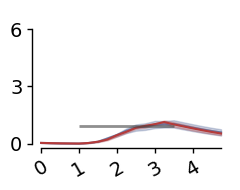

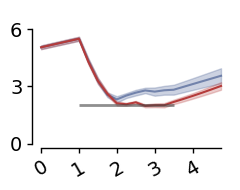

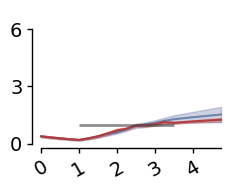

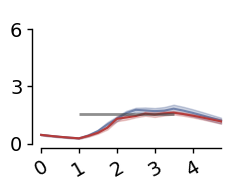

In [14]:
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, sem, ttest_ind

palette = ['#2792c3','#CA4458'] # 框/实心
palette = ['#374f88','#b53b3a'] # 阿修 红70% 蓝80%
color1 = '#444444'
xmin=5
xmax=7.5
start_time=16
end_time=36
for channel in range(4):
    # if channel!=1:
    #     continue
    plt.figure(figsize=(2.5,2))
    times = np.linspace(start_time/4,end_time/4-0.25,end_time-start_time)
    mean1 = np.mean(y_ol_track[:, start_time:end_time, channel],axis=0)
    sem1 = sem(y_ol_track[:, start_time:end_time, channel],axis=0)
    
    plt.plot(times,mean1,linewidth=1.5,color=palette[0],linestyle='-',alpha=0.6, label='open')
    plt.fill_between(times,mean1+sem1, mean1-sem1, color=palette[0],alpha=0.25)

    mean2 = np.mean(y_cl_track[:, start_time:end_time, channel],axis=0)
    sem2 = sem(y_cl_track[:, start_time:end_time, channel],axis=0)
    plt.plot(times,mean2,linewidth=1.5,color=palette[1],alpha=1,label='closed')
    plt.fill_between(times,mean2+sem2, mean2-sem2, color=palette[1],alpha=0.25)

    plt.hlines(y=ref_[channel],xmin=xmin, xmax=xmax,linewidth=2,color=color1,alpha=.6,label='reference')
    
    # mean3 = np.mean(y_rdm_track[:, start_time:end_time, channel],axis=0)
    # sem3 = sem(y_rdm_track[:, start_time:end_time, channel],axis=0)
    # plt.plot(times,mean3,linewidth=1.5,color='green',alpha=1,label='rdm')
    # plt.fill_between(times,mean3+sem3, mean3-sem3, alpha=0.25)

    # 坐标轴调整
    plt.xticks([4,5,6,7,8],labels=[0,1,2,3,4],rotation=30)
    # plt.yticks([0,1,2,3])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_bounds((0,6))
    plt.gca().spines['bottom'].set_bounds((4,8.75))
    plt.gca().spines['bottom'].set_linewidth(1)  # 加粗底部坐标轴 2
    plt.gca().spines['left'].set_linewidth(1)    # 加粗左侧坐标轴

    plt.yticks([0,3,6])
    plt.ylim(-0.2,7)

    plt.tick_params(axis='both', which='major', labelsize=14, width=1) #2

    os.makedirs(dir_+f'/save_img/', exist_ok=True)
    plt.tight_layout()
    plt.savefig(dir_+f'/save_img/wc_tr{channel}.svg',bbox_inches = 'tight', transparent=True)
    plt.savefig(dir_+f'/save_img/wc_tr{channel}.eps',bbox_inches = 'tight', transparent=True)
    print(dir_+f'/save_img/wc_tr{channel}.svg')

In [15]:
# 计算 Random err 指标
def get_rdm_error(data,ref_):
    fixed_point = np.array(ref_)[np.newaxis,np.newaxis,:]
    tr = data.copy()
    distence = np.sqrt(np.sum((tr - fixed_point)**2, axis=-1))
    result = np.sum(distence,axis=-1)
    return result

rdm_err = get_rdm_error(y_rdm_track[:,20:31,:], ref_)

In [16]:
def find_arrived_time(arrive_time,threshold):
    result = []
    for row in arrive_time:
        mask = row <= threshold
        if np.any(mask):
            index = np.argmax(mask)  # 如果行中存在小于threshold的元素，找到第一个True位置
        else:
            index = arrive_time.shape[-1]-1  # 如果没有，返回最大值
            
        result.append(index)
    return np.array(result)

In [17]:
# 计算 Tracking 3指标
def get_evaluation(data,ref_,thes):
    fixed_point = np.array(ref_)[np.newaxis,np.newaxis,:]
    tr = data.copy()
    distence = np.sqrt(np.sum((tr - fixed_point)**2, axis=-1))
    err = np.sum(distence,axis=-1)

    uni, count = np.unique(np.where(distence<=thes)[0],return_counts=True)
    for j in range(distence.shape[0]):
        if j not in uni:
            count = np.append(count,0)      
    keeping_time = count

    arrive_time = find_arrived_time(distence,thes)

    return err, keeping_time, arrive_time

In [18]:
thes = 0.5
err1, keeping_time1, arrive_time1 = get_evaluation(y_ol_track[:,20:31,:],ref_,thes)
err2, keeping_time2, arrive_time2 = get_evaluation(y_cl_track[:,20:31,:],ref_,thes)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


error 
closed-open p=0.005598369870071724
close-random p=7.403142159269443e-08
open-random p=1.2172153453171976e-06

./data_simulation_track/save_img/wc_err.svg


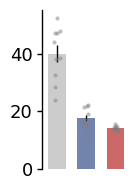

In [19]:
# err 绘图
# ERROR
import seaborn as sns
palette = ['#CCCCCC','#7284AC','#CC6868'] # 阿修 灰 红 蓝

err_ = pd.DataFrame([{'absolute':err2,'strategy':'closed loop'},
{'absolute':err1,'strategy':'open loop'},
{'absolute':rdm_err,'strategy':'random'}])
df_err = err_.explode('absolute')

plt.figure(figsize=(1.5,2))
indices = range(3)
mean1 = err1.mean()
std1 = sem(err1) #err1.std()
mean2 = err2.mean()
std2 = sem(err2) #err2.std()
mean3 = rdm_err.mean()
std3 = sem(rdm_err) #err3.std()
y_ = [mean3,mean1,mean2]
yerr = [std3,std1,std2]
plt.bar(indices,y_,yerr=yerr,width=0.6,alpha=1,color=palette,error_kw={'capsize': 0, 'capthick': 1, 'elinewidth': 1.})

sns.stripplot(x="strategy", y="absolute",order=['random','open loop','closed loop'],
                    data=df_err, jitter=True,alpha=.5,color="gray", size=3, marker='o')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(1.)  # 加粗底部坐标轴1.5
plt.gca().spines['left'].set_linewidth(1.)    # 加粗左侧坐标轴1.5
plt.gca().spines['bottom'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=13, width=1.) #1.7
plt.xticks([])
plt.gca().spines['bottom'].set_bounds((0,2))
plt.xlabel('',fontsize=15)
plt.ylabel('',fontsize=15)

# lines_to_write = f'''error 
# closed-open p={mannwhitneyu(err2,err1,alternative='less')[1]}
# close-random p={mannwhitneyu(err2,rdm_err,alternative='less')[1]}
# open-random p={mannwhitneyu(err1,rdm_err,alternative='less')[1]}\n'''
# print(lines_to_write)

lines_to_write = f'''error 
closed-open p={ttest_ind(err2,err1)[1]}
close-random p={ttest_ind(err2,rdm_err)[1]}
open-random p={ttest_ind(err1,rdm_err)[1]}\n'''
print(lines_to_write)

os.makedirs(dir_+f'/save_img/', exist_ok=True)
plt.tight_layout()
plt.savefig(dir_+f'/save_img/wc_err.svg',bbox_inches = 'tight', transparent=True)
plt.savefig(dir_+f'/save_img/wc_err.eps',bbox_inches = 'tight', transparent=True)
print(dir_+f'/save_img/wc_err.svg')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


arrive
 closed-open p=0.0036107588842394303

./data_simulation_track/save_img/wc_arrive.svg


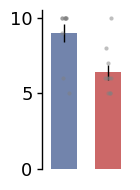

In [20]:
# ARRIVE Time
# palette = ["#00AEEC","#FFAED0"] # b站 框/实心
palette = ['#7284AC','#CC6868'] # 阿修  红 蓝

arrive_times = pd.DataFrame([
    {'absolute':arrive_time2,'strategy':'closed loop'},
    {'absolute':arrive_time1,'strategy':'open loop'}
    ])
arrive_times = arrive_times.explode('absolute')

plt.figure(figsize=(1.5,2))
indices = np.arange(2)
mean1 = arrive_time1.mean()
std1 = sem(arrive_time1)
mean2 = arrive_time2.mean()
std2 = sem(arrive_time2)
y_ = [mean1,mean2]
yerr = [std1,std2]

plt.bar(indices,y_,yerr=yerr,width=0.6,color=palette,error_kw={'capsize': 0, 'capthick': 1, 'elinewidth': 1.}) # 1，1.5
sns.stripplot(x="strategy", y="absolute",order=['open loop','closed loop'],
                    data=arrive_times, jitter=True,alpha=.5,color="gray", size=3, marker='o')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(1.)  # 加粗底部坐标轴
plt.gca().spines['left'].set_linewidth(1.)    # 加粗左侧坐标轴

plt.gca().spines['bottom'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=13, width=1.)
plt.xticks([])
# plt.gca().spines['left'].set_bounds((0,3))
# plt.ylim(-0.3,3)
# plt.yticks([0,1,2,3])
plt.xlabel('',fontsize=15)
plt.ylabel('',fontsize=15)
# plt.tight_layout()

# lines_to_write = f"arrive\n closed-open p={mannwhitneyu(arrive_time2,arrive_time1,alternative='less')[1]}\n"
# print(lines_to_write)

lines_to_write = f"arrive\n closed-open p={ttest_ind(arrive_time2,arrive_time1)[1]}\n"
print(lines_to_write)

os.makedirs(dir_+f'/save_img/', exist_ok=True)
plt.tight_layout()
plt.savefig(dir_+f'/save_img/wc_arrive.svg',bbox_inches = 'tight', transparent=True)
plt.savefig(dir_+f'/save_img/wc_arrive.eps',bbox_inches = 'tight', transparent=True)
print(dir_+f'/save_img/wc_arrive.svg')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


keep
 closed-open p=0.009136597867850814

./data_simulation_track/save_img/wc_keep.svg


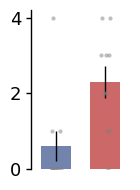

In [21]:
# KEEP Time
palette = ['#7284AC','#CC6868'] # 阿修  红 蓝

keeping_times = pd.DataFrame([
    {'absolute':keeping_time2,'strategy':'closed loop'},
    {'absolute':keeping_time1,'strategy':'open loop'}
    ])
keeping_times = keeping_times.explode('absolute')

plt.figure(figsize=(1.5,2))
indices = np.arange(2)
mean1 = keeping_time1.mean()
std1 = sem(keeping_time1)
mean2 = keeping_time2.mean()
std2 = sem(keeping_time2)

y_ = [mean1,mean2]
yerr = [std1,std2]
plt.bar(indices,y_,yerr=yerr,width=0.6,color=palette,error_kw={'capsize': 0, 'capthick': 1, 'elinewidth': 1.})
sns.stripplot(x="strategy", y="absolute",order=['open loop','closed loop'],
                    data=keeping_times, jitter=True,alpha=.5,color="gray", size=3, marker='o')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().spines['bottom'].set_linewidth(1.)  # 加粗底部坐标轴
plt.gca().spines['left'].set_linewidth(1.)    # 加粗左侧坐标轴

plt.gca().spines['bottom'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=13, width=1.)
plt.xticks([])
# plt.gca().spines['left'].set_bounds((0,3))
# plt.ylim(-0.3,3)
# plt.yticks([0,1,2,3])
plt.xlabel('',fontsize=15)
plt.ylabel('',fontsize=15)
# plt.tight_layout()

# lines_to_write = f"arrive\n closed-open p={mannwhitneyu(arrive_time2,arrive_time1,alternative='less')[1]}\n"
# print(lines_to_write)

lines_to_write = f"keep\n closed-open p={ttest_ind(keeping_time2,keeping_time1)[1]}\n"
print(lines_to_write)

os.makedirs(dir_+f'/save_img/', exist_ok=True)
plt.tight_layout()
plt.savefig(dir_+f'/save_img/wc_keep.svg',bbox_inches = 'tight', transparent=True)
plt.savefig(dir_+f'/save_img/wc_keep.eps',bbox_inches = 'tight', transparent=True)
print(dir_+f'/save_img/wc_keep.svg')


energy
 closed-open p=0.0017607159992473833


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



./data_simulation_track/save_img/wc_energe.svg


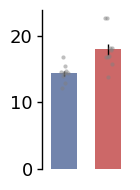

In [22]:
# energy
palette = ['#7284AC','#CC6868'] # 阿修  红 蓝
energy1 = np.sum(np.power(u_ol_track.reshape(10,-1),2),axis=-1)
energy2 = np.sum(np.power(u_cl_track.reshape(10,-1),2),axis=-1)
energys = pd.DataFrame([
    {'absolute':energy2,'strategy':'closed loop'},
    {'absolute':energy1,'strategy':'open loop'}
    ])
energys = energys.explode('absolute')

plt.figure(figsize=(1.5,2))
indices = np.arange(2)
mean1 = energy1.mean()
std1 = sem(energy1)
mean2 = energy2.mean()
std2 = sem(energy2)

y_ = [mean1,mean2]
yerr = [std1,std2]
plt.bar(indices,y_,yerr=yerr,width=0.6,color=palette,error_kw={'capsize': 0, 'capthick': 1, 'elinewidth': 1.})
sns.stripplot(x="strategy", y="absolute",order=['open loop','closed loop'],
                    data=energys, jitter=True,alpha=.5,color="gray", size=3, marker='o')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().spines['bottom'].set_linewidth(1.)  # 加粗底部坐标轴
plt.gca().spines['left'].set_linewidth(1.)    # 加粗左侧坐标轴

plt.gca().spines['bottom'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=13, width=1.)
plt.xticks([])
plt.xlabel('',fontsize=15)
plt.ylabel('',fontsize=15)

lines_to_write = f"energy\n closed-open p={ttest_ind(energy2,energy1)[1]}\n"
print(lines_to_write)

os.makedirs(dir_+f'/save_img/', exist_ok=True)
plt.tight_layout()
plt.savefig(dir_+f'/save_img/wc_energe.svg',bbox_inches = 'tight', transparent=True)
plt.savefig(dir_+f'/save_img/wc_energe.eps',bbox_inches = 'tight', transparent=True)
print(dir_+f'/save_img/wc_energe.svg')


## activating

In [23]:
trials = 10
num_steps=51

x_ol_act = np.zeros((num_observed,trials,num_steps, num_states*2))  # 状态序列
y_ol_act = np.zeros((num_observed,trials,num_steps, num_observed))  # 状态序列
u_ol_act = np.zeros((num_observed,trials,num_steps, num_inputs))  # 状态序列
x_cl_act = np.zeros((num_observed,trials,num_steps, num_states*2))  # 状态序列
y_cl_act = np.zeros((num_observed,trials,num_steps, num_observed))  # 状态序列
u_cl_act = np.zeros((num_observed,trials,num_steps, num_inputs))  # 状态序列
x_rdm_act = np.zeros((num_observed,trials,num_steps, num_states*2))  # 状态序列
y_rdm_act = np.zeros((num_observed,trials,num_steps, num_observed))  # 状态序列
u_rdm_act = np.zeros((num_observed,trials,num_steps, num_inputs))  # 状态序列


for channel in range(num_observed):
    cl_act_controller.control_channel=channel
    ol_act_controller.control_channel=channel
    
    for i in range(trials):
        x_ol_act[channel,i, 0, :] = np.random.uniform(-1, 1, (num_states*2))/10
        x_cl_act[channel,i, 0, :] = x_ol_act[channel,i, 0, :]
        x_rdm_act[channel,i, 0, :] = x_ol_act[channel,i, 0, :]
        for t in range(1, num_steps):
            if t<=20 or t>30:
                u_cl = np.zeros((num_inputs))
                u_ol = np.zeros((num_inputs))
                u_rdm = np.zeros((num_inputs))
                u_ol_act[channel,i, t, :] = u_cl
                u_cl_act[channel,i, t, :] = u_ol
                u_rdm_act[channel,i, t, :] = u_rdm
            else:
                u_rdm = np.random.uniform(-1, 1, (num_inputs))
                cl_act_controller.init_x=model_encode(model,y_cl_act[channel,i, t-1, :])
                cl_act_controller.obtain_optimal_control()
                u_cl=cl_act_controller.u
                if t==21:
                    ol_act_controller.init_x=model_encode(model,y_ol_act[channel,i, t-1, :])
                    ol_act_controller.obtain_optimal_control()
                    u_ol=ol_act_controller.u
                    u_ol_act[channel,i, t:t+10, :] = u_ol.T
                u_cl_act[channel,i, t:t+1, :] = u_cl.T
                u_rdm_act[channel,i, t:t+1, :] = u_rdm.T
            x_cl_act[channel,i, t, :], y_cl_act[channel,i ,t, :] = forward_system(x_cl_act[channel,i, t-1, :],u_cl)
            x_rdm_act[channel,i, t, :], y_rdm_act[channel,i ,t, :] = forward_system(x_rdm_act[channel,i, t-1, :],u_rdm)
            if t>20  and t<=30:
                x_ol_act[channel,i, t, :], y_ol_act[channel,i ,t, :] = forward_system(x_cl_act[channel,i, t-1, :],u_ol[:,t-21])
            else:
                x_ol_act[channel,i, t, :], y_ol_act[channel,i ,t, :] = forward_system(x_cl_act[channel,i, t-1, :],u_ol)


/mnt/dataset1/zhichao/codes/data_driven_surrogate_guides_optimal_neural_stimulation/utils/mpc_setup_scipy.py:91: RuntimeWarning: overflow encountered in exp
  y = np.log(1+np.exp((self.C @ np.maximum(x,0))+self.C_bias))


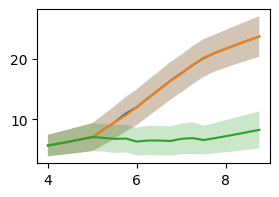

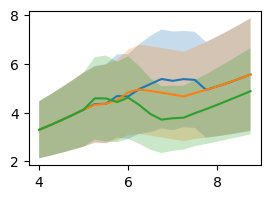

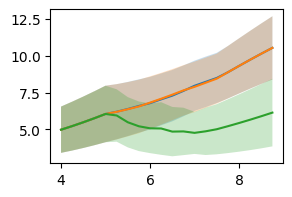

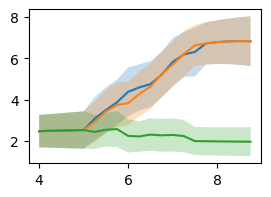

In [24]:
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, sem, ttest_ind

for channel in range(4):
    plt.figure(figsize=(3,2))
    # times = np.linspace(0,num_steps/4-0.25,num_steps)
    times = np.linspace(start_time/4,end_time/4-0.25,end_time-start_time)
    mean1 = np.mean(y_ol_act[channel,:, start_time:end_time, channel],axis=0)
    sem1 = sem(y_ol_act[channel,:, start_time:end_time, channel],axis=0)
    plt.plot(times,mean1)
    plt.fill_between(times,mean1+sem1, mean1-sem1, alpha=0.25)

    mean2 = np.mean(y_cl_act[channel,:, start_time:end_time, channel],axis=0)
    sem2 = sem(y_cl_act[channel,:, start_time:end_time, channel],axis=0)
    plt.plot(times,mean2)
    plt.fill_between(times,mean2+sem2, mean2-sem2, alpha=0.25)

    mean3 = np.mean(y_rdm_act[channel,:, start_time:end_time, channel],axis=0)
    sem3 = sem(y_rdm_act[channel,:, start_time:end_time, channel],axis=0)
    plt.plot(times,mean3)
    plt.fill_between(times,mean3+sem3, mean3-sem3, alpha=0.25)




## inhibiting neural activity

In [25]:
trials = 10
num_steps=51

x_ol_inh = np.zeros((num_observed,trials,num_steps, num_states*2))  # 状态序列
y_ol_inh = np.zeros((num_observed,trials,num_steps, num_observed))  # 状态序列
u_ol_inh = np.zeros((num_observed,trials,num_steps, num_inputs))  # 状态序列
x_cl_inh = np.zeros((num_observed,trials,num_steps, num_states*2))  # 状态序列
y_cl_inh = np.zeros((num_observed,trials,num_steps, num_observed))  # 状态序列
u_cl_inh = np.zeros((num_observed,trials,num_steps, num_inputs))  # 状态序列
x_rdm_inh = np.zeros((num_observed,trials,num_steps, num_states*2))  # 状态序列
y_rdm_inh = np.zeros((num_observed,trials,num_steps, num_observed))  # 状态序列
u_rdm_inh = np.zeros((num_observed,trials,num_steps, num_inputs))  # 状态序列
for channel in range(num_observed):
    cl_inh_controller.control_channel=channel
    ol_inh_controller.control_channel=channel
    for i in range(trials):
        x_ol_inh[channel,i, 0, :] = np.random.uniform(-1, 1, (num_states*2))/10
        x_cl_inh[channel,i, 0, :] = x_ol_inh[channel,i, 0, :]
        x_rdm_inh[channel,i, 0, :] = x_ol_inh[channel,i, 0, :]
        for t in range(1, num_steps):
            if t<=20 or t>30:
                u_cl = np.zeros((num_inputs))
                u_ol = np.zeros((num_inputs))
                u_rdm = np.zeros((num_inputs))
                u_ol_inh[channel,i, t, :] = u_ol
                u_cl_inh[channel,i, t, :] = u_cl
                u_rdm_inh[channel,i, t, :] = u_rdm
            else:
                u_rdm = np.random.uniform(0, 1, (num_inputs))
                cl_inh_controller.init_x=model_encode(model,y_cl_inh[channel,i, t-1, :])
                cl_inh_controller.obtain_optimal_control()
                u_cl=cl_inh_controller.u
                if t==21:
                    ol_inh_controller.init_x=model_encode(model,y_ol_inh[channel,i, t-1, :])
                    ol_inh_controller.obtain_optimal_control()
                    u_ol=ol_inh_controller.u
                    u_ol_inh[channel,i, t:t+10, :] = u_ol.T
                u_cl_inh[channel,i, t:t+1, :] = u_cl.T
                u_rdm_inh[channel,i, t:t+1, :] = u_rdm.T
            x_cl_inh[channel,i, t, :], y_cl_inh[channel,i ,t, :] = forward_system(x_cl_inh[channel,i, t-1, :],u_cl)
            x_rdm_inh[channel,i, t, :], y_rdm_inh[channel,i ,t, :] = forward_system(x_rdm_inh[channel,i, t-1, :],u_rdm)
            if t>20  and t<=30:
                x_ol_inh[channel,i, t, :], y_ol_inh[channel,i ,t, :] = forward_system(x_cl_inh[channel,i, t-1, :],u_ol[:,t-21])
            else:
                x_ol_inh[channel,i, t, :], y_ol_inh[channel,i ,t, :] = forward_system(x_cl_inh[channel,i, t-1, :],u_ol)


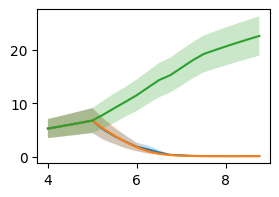

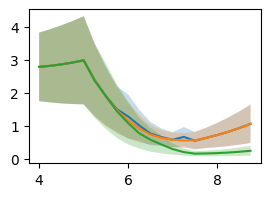

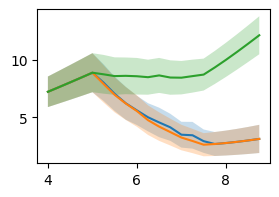

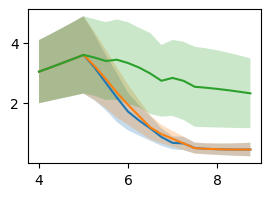

In [26]:
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, sem, ttest_ind

for channel in range(4):
    plt.figure(figsize=(3,2))
    times = np.linspace(start_time/4,end_time/4-0.25,end_time-start_time)
    mean1 = np.mean(y_ol_inh[channel,:, start_time:end_time, channel],axis=0)
    sem1 = sem(y_ol_inh[channel,:, start_time:end_time, channel],axis=0)
    plt.plot(times,mean1)
    plt.fill_between(times,mean1+sem1, mean1-sem1, alpha=0.25)

    mean2 = np.mean(y_cl_inh[channel,:, start_time:end_time, channel],axis=0)
    sem2 = sem(y_cl_inh[channel,:, start_time:end_time, channel],axis=0)
    plt.plot(times,mean2)
    plt.fill_between(times,mean2+sem2, mean2-sem2, alpha=0.25)

    mean3 = np.mean(y_rdm_inh[channel,:, start_time:end_time, channel],axis=0)
    sem3 = sem(y_rdm_inh[channel,:, start_time:end_time, channel],axis=0)
    plt.plot(times,mean3)
    plt.fill_between(times,mean3+sem3, mean3-sem3, alpha=0.25)




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


./data_simulation_track/save_img/wc_open_act_boxplot.svg
./data_simulation_track/save_img/wc_close_act_boxplot.svg


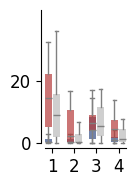

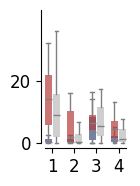

In [27]:
# 定位channel
chs = [str(i) for i in range(1,5)]
ch_positions = np.arange(len(chs))*1.5  # 基础位置数组

# 定义颜色和透明度
palette = ['#374f88','','','#b53b3a'] # 阿修 红70% 蓝80%
color_rand = '#AFAFAF'  # 阿修 灰 80%
color_act = palette[3]
color_inh = palette[0]

border_color_rand = 'grey' #'#666666'  
border_color_act = '#444444'    

# 设置偏移量
offset = 0.28
flierprops = dict(marker='D', markerfacecolor='grey', markeredgecolor='grey',markersize=4)  # 使用菱形
widths = 0.5


for j in range(2):
    plt.figure(figsize=(1.5, 2))
    ax = plt.gca()
    if j == 0:
        data_act_ = y_ol_act[:,:,start_time+5:end_time-5,:]
        data_inh_ = y_ol_inh[:,:,start_time+5:end_time-5,:]
        data_rdm_1 = y_rdm_act[:,:,start_time+5:end_time-5,:]
        data_rdm_2 = y_rdm_inh[:,:,start_time+5:end_time-5,:]
        
    else:
        data_act_ = y_cl_act[:,:,start_time+5:end_time-5,:]
        data_inh_ = y_cl_inh[:,:,start_time+5:end_time-5,:]
        data_rdm_1 = y_rdm_act[:,:,start_time+5:end_time-5,:]
        data_rdm_2 = y_rdm_inh[:,:,start_time+5:end_time-5,:]

    # 绘制inhibition
    for i, ch in enumerate(chs):
        inh_data = data_inh_[i,:,:,i].flatten()
        bp_inh = ax.boxplot(inh_data, positions=[ch_positions[i] - offset], widths=widths, patch_artist=True,
                            boxprops=dict(facecolor=color_inh, color='none',alpha=0.7),
                            medianprops=dict(color=border_color_rand),
                            whiskerprops=dict(color=border_color_rand),
                            capprops=dict(color=border_color_rand),
                            flierprops=flierprops,
                            showfliers=False)

    # 绘制activate
        act_data = data_act_[i,:,:,i].flatten()
        bp_act = ax.boxplot(act_data, positions=[ch_positions[i] - offset], widths=widths, patch_artist=True,
                            boxprops=dict(facecolor=color_act, color='none',alpha=0.7),
                            medianprops=dict(color=border_color_rand),
                            whiskerprops=dict(color=border_color_rand),
                            capprops=dict(color=border_color_rand),
                            flierprops=flierprops,
                            showfliers=False)

    # 绘制random
        rdm_data = np.concatenate((data_rdm_1[i,:,:,i].flatten(),data_rdm_2[i,:,:,i].flatten()))
        bp_rdm = ax.boxplot(rdm_data, positions=[ch_positions[i] + offset], widths=widths, patch_artist=True,
                            boxprops=dict(facecolor=color_rand, color='none',alpha=0.6),
                            medianprops=dict(color=border_color_rand),
                            whiskerprops=dict(color=border_color_rand),
                            capprops=dict(color=border_color_rand),
                            flierprops=flierprops,
                            showfliers=False)

    ax.set_xticks(ch_positions)
    ax.set_xticklabels(chs, fontsize=12) # channel 名

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.set_yticks([0,2,4,6])  # 手动设置y轴刻度
    ax.tick_params(axis='y', labelsize=12)  # 设置y轴刻度字体大小
    ax.spines['left'].set_bounds((0.,43))
    ax.spines['bottom'].set_bounds((-0.5,5))

    os.makedirs(dir_+f'/save_img/', exist_ok=True)
    plt.tight_layout()
    if j == 0:
        f_name = 'open'
    else:
        f_name = 'close'
    # ax.set_title(f_name)
    plt.savefig(dir_+f'/save_img/wc_{f_name}_act_boxplot.svg',bbox_inches = 'tight', transparent=True)
    plt.savefig(dir_+f'/save_img/wc_{f_name}_act_boxplot.eps',bbox_inches = 'tight', transparent=True)
    print(dir_+f'/save_img/wc_{f_name}_act_boxplot.svg')
   

open-act 0.7294547712921787
open-int -0.5614158059349557


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


./data_simulation_track/save_img/wc_open_gain.svg
closed-act 0.7154541302641528
closed-int -0.5845037505298916


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


./data_simulation_track/save_img/wc_closed_gain.svg


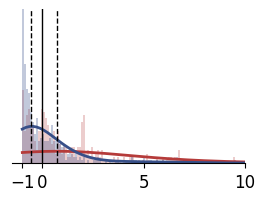

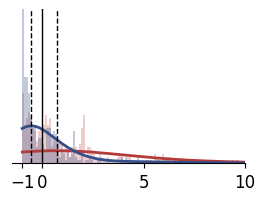

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

palette = ['#374f88','','','#b53b3a'] # 阿修 红70% 蓝80%

for j in range(2):
    if j == 0:
        data_act_ = y_ol_act[:,:,start_time+5:end_time-5,:]
        data_inh_ = y_ol_inh[:,:,start_time+5:end_time-5,:]
        data_rdm_1 = y_rdm_act[:,:,start_time+5:end_time-5,:]
        data_rdm_2 = y_rdm_inh[:,:,start_time+5:end_time-5,:]
    else:
        data_act_ = y_cl_act[:,:,start_time+5:end_time-5,:]
        data_inh_ = y_cl_inh[:,:,start_time+5:end_time-5,:]
        data_rdm_1 = y_rdm_act[:,:,start_time+5:end_time-5,:]
        data_rdm_2 = y_rdm_inh[:,:,start_time+5:end_time-5,:]
    
    rdm_data_list = []
    data_act_list = []
    data_inh_list = []
    for i in range(4):
        rdm_data_list.append(np.concatenate((data_rdm_1[i,:,:,i].flatten(),data_rdm_2[i,:,:,i].flatten())))
        data_act_list.append(data_act_[i,:,:,i].flatten())
        data_inh_list.append(data_inh_[i,:,:,i].flatten())
    rdm_data = np.array(rdm_data_list)
    data_act = np.array(data_act_list)
    data_inh = np.array(data_inh_list)
    
    # 计算gain 
    rdm_median = np.median(rdm_data,axis=1)[:,np.newaxis]
    act_norm = ((data_act-rdm_median)/rdm_median).flatten()
    inh_norm = ((data_inh-rdm_median)/rdm_median).flatten()
    
    # 创建图形
    plt.figure(figsize=(3, 2))

    # 绘制第一组正态分布数据的直方图，增加透明度，去掉边框
    sns.histplot(act_norm, color=palette[3], label='act', binwidth=0.1, alpha=0.25, edgecolor=None,stat='density'
                ,kde=True,line_kws={'linestyle': '-', 'linewidth': 2})

    # 绘制第二组正态分布数据的直方图，增加透明度，去掉边框
    sns.histplot(inh_norm, color=palette[0], label='inh', binwidth=0.1, alpha=0.3, edgecolor=None,stat='density'
                , kde=True,line_kws={'linestyle': '-', 'linewidth': 2})

    # 添加 y=0 的轴线
    plt.axvline(0, color='black', linewidth=1)
    plt.axvline(np.median(act_norm), color='black', linewidth=1, linestyle='--')
    plt.axvline(np.median(inh_norm), color='black', linewidth=1, linestyle='--')
    f_name = ['open','closed']
    # plt.title(aa[j])

    plt.xticks([-1,0,5,10])
    plt.ylabel('')
    plt.xlim([-1.5,10])
    plt.ylim([0,1.2])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().tick_params(left=False)  # 隐藏 y 轴刻度
    plt.gca().set_yticklabels([])      # 隐藏 y 轴标签
    # plt.gca().spines['left'].set_linewidth(1.5)    # 加粗左侧坐标轴
    # plt.tick_params(axis='both', which='major', labelsize=13, width=1.7)
    # plt.gca().spines['bottom'].set_linewidth(1.5)    # 加粗左侧坐标轴
    plt.xticks(fontsize=12)

    print(f"{f_name[j]}-act {np.median(act_norm)}")
    print(f"{f_name[j]}-int {np.median(inh_norm)}")

    plt.savefig(dir_+f'/save_img/wc_{f_name[j]}_gain.svg',bbox_inches = 'tight', transparent=True)
    plt.savefig(dir_+f'/save_img/wc_{f_name[j]}_gain.eps',bbox_inches = 'tight', transparent=True)
    print(dir_+f'/save_img/wc_{f_name[j]}_gain.svg')

In [29]:
from scipy.io import savemat

savemat('wc_nonlinear_simulation_data.mat',{
    'x_cl_act':x_cl_act,
    'y_cl_act':y_cl_act,
    'u_cl_act':u_cl_act,
    'x_ol_act':x_ol_act,
    'y_ol_act':y_ol_act,
    'u_ol_act':u_ol_act,
    'x_rdm_act':x_rdm_act,
    'y_rdm_act':y_rdm_act,
    'u_rdm_act':u_rdm_act,
    'x_cl_inh':x_cl_inh,
    'y_cl_inh':y_cl_inh,
    'u_cl_inh':u_cl_inh,
    'x_ol_inh':x_ol_inh,
    'y_ol_inh':y_ol_inh,
    'u_ol_inh':u_ol_inh,
    'x_rdm_inh':x_rdm_inh,
    'y_rdm_inh':y_rdm_inh,
    'u_rdm_inh':u_rdm_inh,
    'x_cl_track':x_cl_track,
    'y_cl_track':y_cl_track,
    'u_cl_track':u_cl_track,
    'x_ol_track':x_ol_track,
    'y_ol_track':y_ol_track,
    'u_ol_track':u_ol_track,
    'x_rdm_track':x_rdm_track,
    'y_rdm_track':y_rdm_track,
    'u_rdm_track':u_rdm_track,
    'ref':ref_
})